# Outline
- Pre-processing
- Additive model
- Dendrogram/PC
- Multiplicitive model

### Load packages

In [1]:
library(tidyverse)
library(DESeq2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.2     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    com

### Load the 2019 pilot count objects from the image file

In [3]:
curdir <- "/home/jovyan/work/scratch/analysis_output"
imgdir <- file.path(curdir, "img")

imgfile <- file.path(imgdir, "pilotcnt2019.RData")

imgfile

attach(imgfile)

tools::md5sum(imgfile)

### List the objects that have been attached
ls(2)

cnt2019 <- cnt2019
mtdf2019 <- mtdf2019

detach(pos = 2)

[1] "/home/jovyan/work/scratch/analysis_output/img/pilotcnt2019.RData"

The following objects are masked _by_ .GlobalEnv:

    cnt2019, mtdf2019



/home/jovyan/work/scratch/analysis_output/img/pilotcnt2019.RData 
                              "0d1cdfc8bb97baf52ca4f8f33e2c0ae4"

[1] "cnt2019"  "mtdf2019"

### Check dimensions of the two objects

In [4]:
dim(cnt2019)
dim(mtdf2019)

[1]   24 8500

[1] 24 22

In [6]:
mtdf2019 %>% head

Label,sample_year,group,enrich_rep,RNA_sample_num,genotype,condition,libprep_person,enrichment_method,enrichment_short,⋯,i5_primer,i7_primer,library_num,bio_replicate,Nanodrop_260_280,Nanodrop_260_230,Nanodrop_concentration_ng_ul,Bioanalyzer_concentration_ng_ul,RIN_normal_threshold,RIN_lowered_threshold
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1_2019_P_M1,2019,P,1,1,WT,pH4,C,mRNA,M,⋯,i501,i701,1,1,2.14,1.52,293,197,N/A,9.8
2_2019_P_M1,2019,P,1,2,WT,pH4,C,mRNA,M,⋯,i502,i701,2,2,2.12,1.79,290,225,N/A,9.9
3_2019_P_M1,2019,P,1,3,WT,pH4,C,mRNA,M,⋯,i503,i701,3,3,2.11,2.49,302,241,N/A,9.9
4_2019_P_M1,2019,P,1,4,WT,pH4,P,mRNA,M,⋯,i504,i701,4,4,2.13,1.15,296,189,N/A,9.7
5_2019_P_M1,2019,P,1,5,WT,pH4,P,mRNA,M,⋯,i505,i701,5,5,2.09,2.42,337,268,10,10.0
6_2019_P_M1,2019,P,1,6,WT,pH4,P,mRNA,M,⋯,i506,i701,6,6,2.08,2.40,319,276,10,10.0


In [7]:
cnt2019[,1:5]

Label,CNAG_00001,CNAG_00002,CNAG_00003,CNAG_00004
<chr>,<int>,<int>,<int>,<int>
1_2019_P_M1,0,158,201,904
10_2019_P_M1,0,119,131,513
11_2019_P_M1,0,90,121,573
12_2019_P_M1,0,81,151,533
13_2019_P_M1,0,188,215,474
14_2019_P_M1,0,177,154,440
15_2019_P_M1,0,216,197,425
16_2019_P_M1,0,224,195,548
17_2019_P_M1,0,234,211,517


Prepare columnData DataFrame and countData (matrix object)
- columnData --- metadata
- countData  --- count matrix

In [8]:
# columnData --- metadata
mtdf2019 %>%
    DataFrame ->
        columnData

### Add the labels as rownames
rownames(columnData) <- columnData[["Label"]]

columnData[, c("Label", "genotype", "condition")] %>% head

DataFrame with 6 rows and 3 columns
                  Label    genotype   condition
            <character> <character> <character>
1_2019_P_M1 1_2019_P_M1          WT         pH4
2_2019_P_M1 2_2019_P_M1          WT         pH4
3_2019_P_M1 3_2019_P_M1          WT         pH4
4_2019_P_M1 4_2019_P_M1          WT         pH4
5_2019_P_M1 5_2019_P_M1          WT         pH4
6_2019_P_M1 6_2019_P_M1          WT         pH4

In [ ]:
### Note that libraries are across rows and libraries across columns
### DESeq2 requires that the matrix is transposed as that the gene names become row names
cnt2019[1:4,1:5]

In [9]:
### Transpose the count matrix (so that libraries are across the columns and genes across rows) 
### Note that as.matrix() converts the tibble to a matrix object
cnt2019 %>%
    gather(key = gene, value = value, 2:ncol(cnt2019)) %>% 
            spread_(key = names(cnt2019)[1],value = 'value') %>%
                column_to_rownames("gene") %>%
                    as.matrix ->
                        countData

countData[1:5, 1:6]




,1_2019_P_M1,10_2019_P_M1,11_2019_P_M1,12_2019_P_M1,13_2019_P_M1,14_2019_P_M1
CNAG_00001,0,0,0,0,0,0
CNAG_00002,158,119,90,81,188,177
CNAG_00003,201,131,121,151,215,154
CNAG_00004,904,513,573,533,474,440
CNAG_00005,22,24,18,20,25,13


### Reorder the columns of the count matrix according to the order of Label in columnData

In [11]:
### The two variables coincide
setequal(columnData[["Label"]], colnames(countData))
### but they are identical as they follow different orders
identical(columnData[["Label"]], colnames(countData))

[1] TRUE

[1] FALSE

### Reorder the columns of countData 

In [13]:
countData <- countData[,columnData[["Label"]]]

In [14]:
countData[1:4,1:5]

,1_2019_P_M1,2_2019_P_M1,3_2019_P_M1,4_2019_P_M1,5_2019_P_M1
CNAG_00001,0,0,0,0,0
CNAG_00002,158,204,149,176,161
CNAG_00003,201,156,161,171,162
CNAG_00004,904,902,941,795,849


### make sure that labels match

In [15]:
### The two variables coincide
setequal(columnData[["Label"]], colnames(countData))
### but they are identical as they follow different orders
identical(columnData[["Label"]], colnames(countData))

[1] TRUE

[1] TRUE

### Make DESeq object on the basis of the counts

The design option allows you to specify an additive or a multiplicitive model

Additive model

In [16]:
dds_add <- DESeqDataSetFromMatrix(
    countData,                       # Count matrix
    columnData,                      # metadata
    ~ condition + genotype) # design formula

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

Multiplicative model

In [18]:
dds_mult <- DESeqDataSetFromMatrix(
    countData,                       # Count matrix
    columnData,                      # metadata
    ~ condition + genotype + condition:genotype) # design formula

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

In the following demonstration, we will use the additive model. The multiplicitive model will be illustrated in the appendix below.

In [19]:
dds <- dds_add

# Inspect object & Slots of an S4 class

Let's has a look at the object we have created.

In [20]:
dds

class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(1): counts
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(0):
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(22): Label sample_year ... RIN_normal_threshold
  RIN_lowered_threshold

see the class of dds object

In [21]:
class(dds)

[1] "DESeqDataSet"
attr(,"package")
[1] "DESeq2"

DESeqDataSet is a S4 object. Recall that a S4 object was taught when introducing bioconductor. Note that S4 objects allow users to wrap up multiple elements into a single variables where each element is called a slot.

In [22]:
slotNames(dds)

[1] "design"             "dispersionFunction" "rowRanges"         
[4] "colData"            "assays"             "NAMES"             
[7] "elementMetadata"    "metadata"

The metadata (columnData) is stored in the slot `colData`

In [23]:
dds@colData %>% as.data.frame %>% head(3)

,Label,sample_year,group,enrich_rep,RNA_sample_num,genotype,condition,libprep_person,enrichment_method,enrichment_short,⋯,i5_primer,i7_primer,library_num,bio_replicate,Nanodrop_260_280,Nanodrop_260_230,Nanodrop_concentration_ng_ul,Bioanalyzer_concentration_ng_ul,RIN_normal_threshold,RIN_lowered_threshold
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1_2019_P_M1,1_2019_P_M1,2019,P,1,1,WT,pH4,C,mRNA,M,⋯,i501,i701,1,1,2.14,1.52,293,197,N/A,9.8
2_2019_P_M1,2_2019_P_M1,2019,P,1,2,WT,pH4,C,mRNA,M,⋯,i502,i701,2,2,2.12,1.79,290,225,N/A,9.9
3_2019_P_M1,3_2019_P_M1,2019,P,1,3,WT,pH4,C,mRNA,M,⋯,i503,i701,3,3,2.11,2.49,302,241,N/A,9.9


The design formula is stored in the slot `design`. The design holds the R formula which expresses how the counts depend on the variables in colData.

In [24]:
dds@design

~condition + genotype

The first thing you may want to do is **have a look at the raw counts** you have imported. The `DESeq2::counts` function extracts a matrix of counts (with the genes along the rows and samples along the columns). Let us first verify the dimension of this matrix.

In [25]:
dim(counts(dds))

[1] 8499   24

In [26]:
head(counts(dds),3)

,1_2019_P_M1,2_2019_P_M1,3_2019_P_M1,4_2019_P_M1,5_2019_P_M1,6_2019_P_M1,7_2019_P_M1,8_2019_P_M1,9_2019_P_M1,10_2019_P_M1,⋯,15_2019_P_M1,16_2019_P_M1,17_2019_P_M1,18_2019_P_M1,19_2019_P_M1,20_2019_P_M1,21_2019_P_M1,22_2019_P_M1,23_2019_P_M1,24_2019_P_M1
CNAG_00001,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_00002,158,204,149,176,161,148,172,169,124,119,⋯,216,224,234,338,191,201,192,166,202,235
CNAG_00003,201,156,161,171,162,103,172,170,175,131,⋯,197,195,211,201,118,133,109,113,154,169


This slot returns gene specific information (it will be populated later)

In [27]:
dds@dispersionFunction

function () 
NULL
<bytecode: 0x56024db24780>

# Estimate Size Factors and Dispersion Parameters

You recall that DESeq requires that  we have estimates for sample specific size factors and gene specific dispersion factors. More specifically, recall that DESeq models the count $K_{ij}$ (gene $i$, sample $j$) as negative binomial with mean $\mu_{ij}$ and dispersion parameter $\alpha_i$. Here $\mu_{ij}=s_j q_{ij}$ where $\log_2(q_{ij}) = \beta_{0i} + \beta_{1i} z_j$. Here $s_j$ is the sample $j$ specific size factor.

**Summarize of notation**
- $K_{ij}$ denotes the observed **number of reads** mapped to gene $i$ for sample $j$
- $K_{ij}$ follows a **negative binomial distribution** with
    - **Mean** $\mu_{ij}$
    - **Dispersion parameter** $\alpha_i$
- Modelling
    - $K_{ij} \sim NB(\mu_{ij}, \alpha_i)$
    - $\mu_{ij} = s_{j}q_{ij}$
        - $s_j$ is sample $j$ specific normalization constant
    - $\log_2(q_{ij}) = \beta_{0i} + \beta_{1i} z_j$

## 01 Size Factors
 We begin by estimating the size factors $s_1,\ldots,s_n$:

In [28]:
dds <- estimateSizeFactors(dds)

Now, compare the dds object to that of before applying the estimateSizeFactors() function. What has changed? What remains unchanged?

In [29]:
dds

class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(1): counts
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(0):
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(23): Label sample_year ... RIN_lowered_threshold
  sizeFactor

Note that there is a **sizeFactor** added to **colData**. Let's look at it more carefully

```
> dds # (before estimateSizeFactors)
class: DESeqDataSet 
dim: 8497 24 
metadata(1): version
assays(1): counts
rownames(8497): CNAG_00001 CNAG_00002 ... ENSRNA049551964 ENSRNA049551993
rowData names(0):
colnames(24): 1_RZ_J 10_RZ_C ... 47_RZ_P 9_RZ_C
colData names(10): Label Strain ... prob.unique depth

> dds # (after estimateSizeFactors)
class: DESeqDataSet 
dim: 8497 24 
metadata(1): version
assays(1): counts
rownames(8497): CNAG_00001 CNAG_00002 ... ENSRNA049551964 ENSRNA049551993
rowData names(0):
colnames(24): 1_RZ_J 10_RZ_C ... 47_RZ_P 9_RZ_C
colData names(11): Label Strain ... depth sizeFactor <------ 
```

You can also get the size factors directly

In [30]:
sizeFactors(dds)

1_2019_P_M1  2_2019_P_M1  3_2019_P_M1  4_2019_P_M1  5_2019_P_M1  6_2019_P_M1 
   1.5916393    1.6587110    1.5128946    1.4196686    1.4373847    1.2371000 
 7_2019_P_M1  8_2019_P_M1  9_2019_P_M1 10_2019_P_M1 11_2019_P_M1 12_2019_P_M1 
   1.4014829    1.4421725    1.1744409    1.0763647    1.0421627    0.9712383 
13_2019_P_M1 14_2019_P_M1 15_2019_P_M1 16_2019_P_M1 17_2019_P_M1 18_2019_P_M1 
   0.7709868    0.7523820    0.7176796    0.8978403    0.8936416    0.9316181 
19_2019_P_M1 20_2019_P_M1 21_2019_P_M1 22_2019_P_M1 23_2019_P_M1 24_2019_P_M1 
   0.7494357    0.7755715    0.5838325    0.6343998    0.7551861    0.8088364

 It is preferable to limit the number of decimal places. Next show the size factors rounded to 3 decimal places

In [31]:
round(sizeFactors(dds),3)

1_2019_P_M1  2_2019_P_M1  3_2019_P_M1  4_2019_P_M1  5_2019_P_M1  6_2019_P_M1 
       1.592        1.659        1.513        1.420        1.437        1.237 
 7_2019_P_M1  8_2019_P_M1  9_2019_P_M1 10_2019_P_M1 11_2019_P_M1 12_2019_P_M1 
       1.401        1.442        1.174        1.076        1.042        0.971 
13_2019_P_M1 14_2019_P_M1 15_2019_P_M1 16_2019_P_M1 17_2019_P_M1 18_2019_P_M1 
       0.771        0.752        0.718        0.898        0.894        0.932 
19_2019_P_M1 20_2019_P_M1 21_2019_P_M1 22_2019_P_M1 23_2019_P_M1 24_2019_P_M1 
       0.749        0.776        0.584        0.634        0.755        0.809

Now that the size factors have been estimated, we can get "normalized" counts. Here we print three data frames together to easily compare them.

In [32]:
# original count
head(counts(dds), 3)

# normalized count
head(counts(dds, normalize = TRUE), 3)

# normalized manually using size factors
counts(dds)[1:3,] %>% 
    apply(., 1, function(row){row / sizeFactors(dds)}) %>%
    t

,1_2019_P_M1,2_2019_P_M1,3_2019_P_M1,4_2019_P_M1,5_2019_P_M1,6_2019_P_M1,7_2019_P_M1,8_2019_P_M1,9_2019_P_M1,10_2019_P_M1,⋯,15_2019_P_M1,16_2019_P_M1,17_2019_P_M1,18_2019_P_M1,19_2019_P_M1,20_2019_P_M1,21_2019_P_M1,22_2019_P_M1,23_2019_P_M1,24_2019_P_M1
CNAG_00001,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_00002,158,204,149,176,161,148,172,169,124,119,⋯,216,224,234,338,191,201,192,166,202,235
CNAG_00003,201,156,161,171,162,103,172,170,175,131,⋯,197,195,211,201,118,133,109,113,154,169


,1_2019_P_M1,2_2019_P_M1,3_2019_P_M1,4_2019_P_M1,5_2019_P_M1,6_2019_P_M1,7_2019_P_M1,8_2019_P_M1,9_2019_P_M1,10_2019_P_M1,⋯,15_2019_P_M1,16_2019_P_M1,17_2019_P_M1,18_2019_P_M1,19_2019_P_M1,20_2019_P_M1,21_2019_P_M1,22_2019_P_M1,23_2019_P_M1,24_2019_P_M1
CNAG_00001,0.00000,0.00000,0.00000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
CNAG_00002,99.26872,122.98706,98.48671,123.9726,112.0090,119.63463,122.7271,117.1843,105.5822,110.5573,⋯,300.9700,249.4876,261.8499,362.8096,254.8584,259.1637,328.8614,261.6647,267.4837,290.5408
CNAG_00003,126.28489,94.04893,106.41852,120.4506,112.7047,83.25923,122.7271,117.8777,149.0071,121.7060,⋯,274.4957,217.1878,236.1125,215.7536,157.4518,171.4864,186.6974,178.1211,203.9232,208.9421


,1_2019_P_M1,2_2019_P_M1,3_2019_P_M1,4_2019_P_M1,5_2019_P_M1,6_2019_P_M1,7_2019_P_M1,8_2019_P_M1,9_2019_P_M1,10_2019_P_M1,⋯,15_2019_P_M1,16_2019_P_M1,17_2019_P_M1,18_2019_P_M1,19_2019_P_M1,20_2019_P_M1,21_2019_P_M1,22_2019_P_M1,23_2019_P_M1,24_2019_P_M1
CNAG_00001,0.00000,0.00000,0.00000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
CNAG_00002,99.26872,122.98706,98.48671,123.9726,112.0090,119.63463,122.7271,117.1843,105.5822,110.5573,⋯,300.9700,249.4876,261.8499,362.8096,254.8584,259.1637,328.8614,261.6647,267.4837,290.5408
CNAG_00003,126.28489,94.04893,106.41852,120.4506,112.7047,83.25923,122.7271,117.8777,149.0071,121.7060,⋯,274.4957,217.1878,236.1125,215.7536,157.4518,171.4864,186.6974,178.1211,203.9232,208.9421


**Exercise:** How do you get the raw counts for gene  "GeneID: CNAG_05845"?

In [33]:
counts(dds, normalize = TRUE)["CNAG_05845",]

1_2019_P_M1  2_2019_P_M1  3_2019_P_M1  4_2019_P_M1  5_2019_P_M1  6_2019_P_M1 
    1753.538     1483.682     1395.999     1526.413     1540.993     1662.760 
 7_2019_P_M1  8_2019_P_M1  9_2019_P_M1 10_2019_P_M1 11_2019_P_M1 12_2019_P_M1 
    1483.429     1396.504     1611.831     1532.009     1625.466     1693.714 
13_2019_P_M1 14_2019_P_M1 15_2019_P_M1 16_2019_P_M1 17_2019_P_M1 18_2019_P_M1 
    1629.081     1600.251     1574.519     1551.501     1732.238     1523.156 
19_2019_P_M1 20_2019_P_M1 21_2019_P_M1 22_2019_P_M1 23_2019_P_M1 24_2019_P_M1 
    1822.705     1799.963     1872.112     1692.939     1832.661     1791.462

In [39]:
### Divide 
counts(dds, normalize = FALSE)["CNAG_05845",]/sizeFactors(dds)

1_2019_P_M1  2_2019_P_M1  3_2019_P_M1  4_2019_P_M1  5_2019_P_M1  6_2019_P_M1 
    1753.538     1483.682     1395.999     1526.413     1540.993     1662.760 
 7_2019_P_M1  8_2019_P_M1  9_2019_P_M1 10_2019_P_M1 11_2019_P_M1 12_2019_P_M1 
    1483.429     1396.504     1611.831     1532.009     1625.466     1693.714 
13_2019_P_M1 14_2019_P_M1 15_2019_P_M1 16_2019_P_M1 17_2019_P_M1 18_2019_P_M1 
    1629.081     1600.251     1574.519     1551.501     1732.238     1523.156 
19_2019_P_M1 20_2019_P_M1 21_2019_P_M1 22_2019_P_M1 23_2019_P_M1 24_2019_P_M1 
    1822.705     1799.963     1872.112     1692.939     1832.661     1791.462

**Exercise:** Get a summary (mean, median, quantiles etc ) of the size factors

In [34]:
summary(sizeFactors(dds))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5838  0.7670  0.9514  1.0515  1.4060  1.6587 

Before going to the next step, let's look at the dispersionFunction slot

In [35]:
# still empty
dds@dispersionFunction

function () 
NULL
<bytecode: 0x56024db24780>

## 02 Dispersion Parameters
Next, we get the dispersion factors $\alpha_1,\ldots,\alpha_{m}$

In [40]:
dds <- estimateDispersions(dds)

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


Now inspect the dds object again and note that the rowRanges slot has extra information ("metadata column names(0):" before versus "column names(9): baseMean baseVar ... dispOutlier dispMAP")
- before: 
    - `metadata column names(0):`
- after:  
    - `column names(9): baseMean baseVar ...`

In [41]:
dds

class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(2): counts mu
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(10): baseMean baseVar ... dispOutlier dispMAP
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(23): Label sample_year ... RIN_lowered_threshold
  sizeFactor

Can you notice the difference?
```
> dds (before dispersion)
class: DESeqDataSet 
dim: 8497 24 
metadata(1): version
assays(1): counts
rownames(8497): CNAG_00001 CNAG_00002 ... ENSRNA049551964 ENSRNA049551993
rowData names(0):
colnames(24): 1_RZ_J 10_RZ_C ... 47_RZ_P 9_RZ_C
colData names(11): Label Strain ... depth sizeFactor

> dds (after dispersion)
class: DESeqDataSet 
dim: 8497 24 
metadata(1): version
assays(2): counts mu
rownames(8497): CNAG_00001 CNAG_00002 ... ENSRNA049551964 ENSRNA049551993
rowData names(9): baseMean baseVar ... dispOutlier dispMAP <------
colnames(24): 1_RZ_J 10_RZ_C ... 47_RZ_P 9_RZ_C
colData names(11): Label Strain ... depth sizeFactor
```

Note that the dispersionfunction slot is now populated

In [42]:
dds@dispersionFunction

function (q) 
coefs[1] + coefs[2]/q
<bytecode: 0x56025d4b6210>
<environment: 0x56025d4b6868>
attr(,"coefficients")
asymptDisp  extraPois 
0.01418035 0.87630661 
attr(,"fitType")
[1] "parametric"
attr(,"varLogDispEsts")
[1] 0.9024663
attr(,"dispPriorVar")
[1] 0.8025493

We can extract the gene specific dispersion factors using dispersions(). Note that there will be one number per gene. We look at the first four genes (rounded to 4 decimal places)

In [43]:
alphas <- dispersions(dds)

Verify that the number of dispersion factors equals the number of genes

In [44]:
# number of disperion factors
length(alphas)

[1] 8499

In [45]:
# number of genes
nrow(dds)

[1] 8499

Print the dispersion factors for the first four genes rounded to four decimal points

In [46]:
round(alphas[1:4], 4)

[1]     NA 0.0132 0.0231 0.0044

Extract the metadata using mcols() for the first four genes

| Terms       | Description                                   |
|-------------|-----------------------------------------------|
| baseMean    |     mean of normalized counts for all samples |
| baseVar     | variance of normalized counts for all samples |
| allZero     |                all counts for a gene are zero |
| dispGeneEst |             gene-wise estimates of dispersion |
| dispFit     |                   fitted values of dispersion |
| dispersion  |                  final estimate of dispersion |
| dispIter    |                          number of iterations |
| dispOut     |                 dispersion flagged as outlier |
| dispMAP     |                 maximum a posteriori estimate |


In [47]:
mcols(dds)[1:4,] %>% as.data.frame

,baseMean,baseVar,allZero,dispGeneEst,dispGeneIter,dispFit,dispersion,dispIter,dispOutlier,dispMAP
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
CNAG_00001,0.0000,0.000,TRUE,NA,NA,NA,NA,NA,NA,NA
CNAG_00002,192.4564,8133.183,FALSE,0.012090962,9,0.01873362,0.013202310,9,FALSE,0.013202310
CNAG_00003,164.9908,3089.489,FALSE,0.023820456,10,0.01949159,0.023065791,7,FALSE,0.023065791
CNAG_00004,571.0547,1819.185,FALSE,0.003107148,5,0.01571489,0.004430586,12,FALSE,0.004430586


**Exercise:** Provide statistical summaries of the dispersion factors

In [48]:
summary(dispersions(dds))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0011  0.0073  0.0138  0.1764  0.0288 24.0000     348 

**Exercise:** Summarize the dispersion factors using a box plot (may want to log transform)

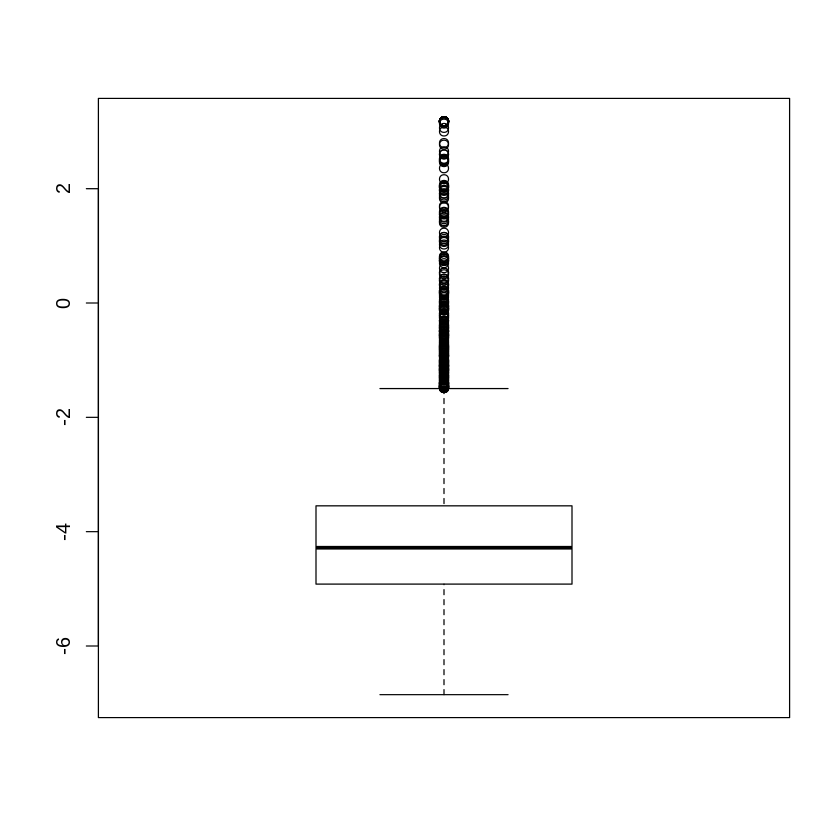

In [49]:
boxplot(log(dispersions(dds)))

# Differential Expression Analysis
We can now conduct a differential expression analysis using the DESeq() function. Keep in mind that to get to this step, we first estimated the size factors and then the dispersion parameters.

In [50]:
### Carry out DE analysis
ddsDE <- DESeq(dds)

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [52]:
### Look at object
ddsDE

class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(4): counts mu H cooks
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(26): baseMean baseVar ... deviance maxCooks
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(23): Label sample_year ... RIN_lowered_threshold
  sizeFactor

In [54]:
### Look at some f the results
results(ddsDE)

log2 fold change (MLE): genotype WT vs sre1d 
Wald test p-value: genotype WT vs sre1d 
DataFrame with 8499 rows and 6 columns
                        baseMean     log2FoldChange              lfcSE
                       <numeric>          <numeric>          <numeric>
CNAG_00001                     0                 NA                 NA
CNAG_00002      192.456384076694 0.0459290105698189 0.0812849125012254
CNAG_00003      164.990819436254 0.0432979308487266  0.101045100070341
CNAG_00004      571.054651467718 0.0347715410374543 0.0464312203030827
CNAG_00005      28.7106195205257 -0.377056805602812  0.192347436642309
...                          ...                ...                ...
ENSRNA049551942                0                 NA                 NA
ENSRNA049551964                0                 NA                 NA
ENSRNA049551993                0                 NA                 NA
large_MTrRNA    5333.97356461621 -0.396337460272526   0.13434088145007
small_MTrRNA    1705.7

Note that currently, the model we have is an additive model, which does not include the interaction term of `Media` and `Strain`

In [55]:
design(dds)
columnData

~condition + genotype

DataFrame with 24 rows and 22 columns
                    Label sample_year       group enrich_rep RNA_sample_num
              <character>   <numeric> <character>  <numeric>      <numeric>
1_2019_P_M1   1_2019_P_M1        2019           P          1              1
2_2019_P_M1   2_2019_P_M1        2019           P          1              2
3_2019_P_M1   3_2019_P_M1        2019           P          1              3
4_2019_P_M1   4_2019_P_M1        2019           P          1              4
5_2019_P_M1   5_2019_P_M1        2019           P          1              5
...                   ...         ...         ...        ...            ...
20_2019_P_M1 20_2019_P_M1        2019           P          1             20
21_2019_P_M1 21_2019_P_M1        2019           P          1             21
22_2019_P_M1 22_2019_P_M1        2019           P          1             22
23_2019_P_M1 23_2019_P_M1        2019           P          1             23
24_2019_P_M1 24_2019_P_M1        2019           P 

We can get the results for the differential expression analysis using results(). Here, we can compare two group of samples specified by the contrast. (If not, the default contrast would be the last term in your additive model `design(dds)`).

In [61]:
# DE with respect to condition
myres_condition4v8 <- results(ddsDE, contrast = c("condition", "pH4", "pH8"))
myres_condition4v8

log2 fold change (MLE): condition pH4 vs pH8 
Wald test p-value: condition pH4 vs pH8 
DataFrame with 8499 rows and 6 columns
                        baseMean      log2FoldChange              lfcSE
                       <numeric>           <numeric>          <numeric>
CNAG_00001                     0                  NA                 NA
CNAG_00002      192.456384076694   -1.34351851614176 0.0813854454817818
CNAG_00003      164.990819436254  -0.831905577724638  0.101018400723969
CNAG_00004      571.054651467718 -0.0871138906737344 0.0465166816365353
CNAG_00005      28.7106195205257   -1.29275886849841  0.192729463777133
...                          ...                 ...                ...
ENSRNA049551942                0                  NA                 NA
ENSRNA049551964                0                  NA                 NA
ENSRNA049551993                0                  NA                 NA
large_MTrRNA    5333.97356461621  -0.948564278537808  0.134340883270906
small_MTrR

In [66]:
# DE with respect to condition (flip order)
myres_condition8v4 <- results(ddsDE, contrast = c("condition", "pH8", "pH4"))
myres_condition8v4

log2 fold change (MLE): condition pH8 vs pH4 
Wald test p-value: condition pH8 vs pH4 
DataFrame with 8499 rows and 6 columns
                        baseMean     log2FoldChange              lfcSE
                       <numeric>          <numeric>          <numeric>
CNAG_00001                     0                 NA                 NA
CNAG_00002      192.456384076694   1.34351851614176 0.0813854454817818
CNAG_00003      164.990819436254  0.831905577724638  0.101018400723969
CNAG_00004      571.054651467718 0.0871138906737344 0.0465166816365353
CNAG_00005      28.7106195205257   1.29275886849841  0.192729463777133
...                          ...                ...                ...
ENSRNA049551942                0                 NA                 NA
ENSRNA049551964                0                 NA                 NA
ENSRNA049551993                0                 NA                 NA
large_MTrRNA    5333.97356461621  0.948564278537808  0.134340883270906
small_MTrRNA    1705.7

In [67]:
### DE with respect to genotype
myres_strainvWT <- results(ddsDE, contrast = c("genotype", "sre1d", "WT"))
myres_strainvWT

log2 fold change (MLE): genotype sre1d vs WT 
Wald test p-value: genotype sre1d vs WT 
DataFrame with 8499 rows and 6 columns
                        baseMean      log2FoldChange              lfcSE
                       <numeric>           <numeric>          <numeric>
CNAG_00001                     0                  NA                 NA
CNAG_00002      192.456384076694 -0.0459290105698189 0.0812849125012254
CNAG_00003      164.990819436254 -0.0432979308487266  0.101045100070341
CNAG_00004      571.054651467718 -0.0347715410374543 0.0464312203030827
CNAG_00005      28.7106195205257   0.377056805602812  0.192347436642309
...                          ...                 ...                ...
ENSRNA049551942                0                  NA                 NA
ENSRNA049551964                0                  NA                 NA
ENSRNA049551993                0                  NA                 NA
large_MTrRNA    5333.97356461621   0.396337460272526   0.13434088145007
small_MTrR

Let's look at the results for the first four genes

In [84]:
### Tidy the results
myres_condition8v4 <- results(ddsDE, contrast = c("condition", "pH8", "pH4"), tidy = TRUE)
myres_condition8v4

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CNAG_00001,0.00000,NA,NA,NA,NA,NA
CNAG_00002,192.45638,1.343518516,0.08138545,16.5080932,3.208624e-61,2.870856e-60
CNAG_00003,164.99082,0.831905578,0.10101840,8.2351886,1.792750e-16,4.795769e-16
CNAG_00004,571.05465,0.087113891,0.04651668,1.8727452,6.110358e-02,7.489553e-02
CNAG_00005,28.71062,1.292758868,0.19272946,6.7076349,1.978041e-11,4.320208e-11
CNAG_00006,3147.39964,-0.139327775,0.04956000,-2.8112951,4.934250e-03,6.756102e-03
CNAG_00007,1484.87545,-0.747920328,0.08053624,-9.2867544,1.590647e-20,4.927921e-20
CNAG_00008,938.01932,-0.079110196,0.04765929,-1.6599115,9.693226e-02,1.159517e-01
CNAG_00009,305.19881,-0.558838066,0.09968395,-5.6060989,2.069377e-08,3.933651e-08


In [86]:
### Tidy the results and sort in ascending order by adjusted p-value
myres_condition8v4 <- results(ddsDE, contrast = c("condition", "pH8", "pH4"), tidy = TRUE)

myres_condition8v4 %>% 
    arrange(desc(-padj)) %>% 
        head(100)

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CNAG_00275,1072.9219,-4.048106,0.10667356,-37.94854,0,0
CNAG_00309,539.1312,-3.331524,0.08444635,-39.45137,0,0
CNAG_00409,1093.4775,-5.030655,0.07452918,-67.49913,0,0
CNAG_00531,15371.8856,3.563691,0.05663035,62.92900,0,0
CNAG_00601,506.4752,4.661577,0.09625726,48.42832,0,0
CNAG_00897,12255.8281,4.856924,0.07970883,60.93332,0,0
CNAG_01272,49334.5209,1.961009,0.04521777,43.36812,0,0
CNAG_01275,2534.1015,2.273088,0.04888985,46.49406,0,0
CNAG_01344,3528.6160,-1.582122,0.04028591,-39.27234,0,0


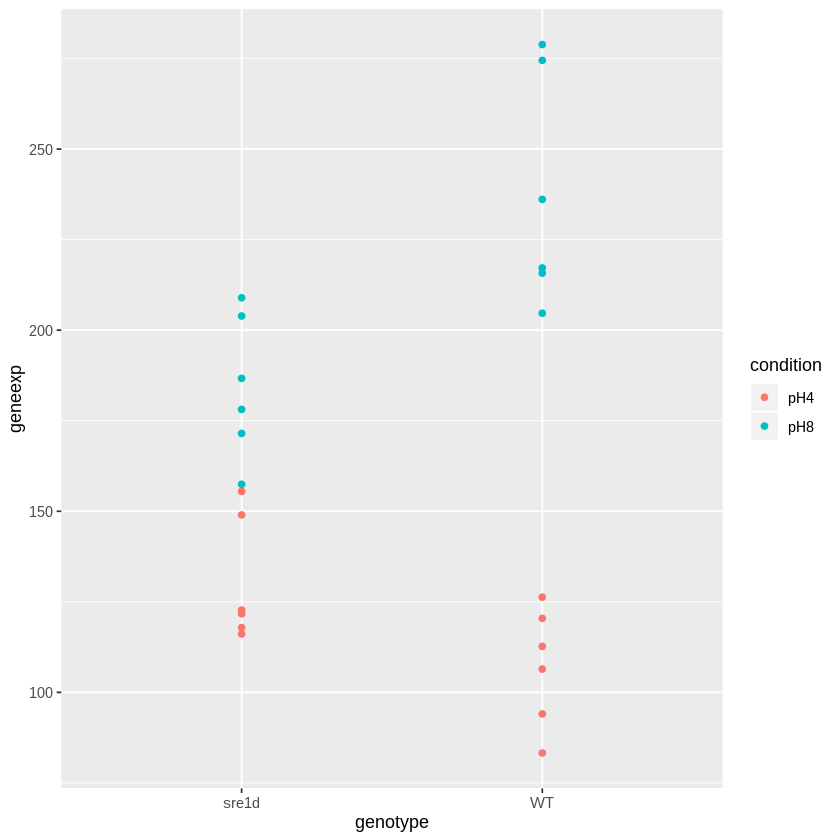

In [137]:
myDEplotData <- function(mydds, geneid, mergelab) {
    counts(mydds, normalize = TRUE) %>%
        as_tibble(rownames="gene") %>%
        filter(gene == geneid) %>%
        gather(Label, geneexp, -gene) %>%
        select(-gene) -> genedat

    colData(mydds) %>%
        as.data.frame %>%
        as_tibble %>%
        full_join(genedat, by = mergelab) -> genedat
    
    return(genedat)
}

#myDEplotData(dds, "CNAG_00003", "Label")[,c("Label", "genotype", "condition" , "geneexp")]

myDEplot0 <- function(mydds, geneid, grpvar, mergelab) {
    mydat <- myDEplotData(mydds, geneid, mergelab)
    ggplot(mydat, aes(x = condition, y = geneexp))+ geom_point()
}



myDEplot1 <- function(mydds, geneid, grpvar, mergelab) {
    mydat <- myDEplotData(mydds, geneid, mergelab)
    ggplot(mydat, aes_string(x=grpvar, y = "geneexp"))+ geom_point()
}


myDEplot2 <- function(mydds, geneid, grpvar, mergelab) {
    mydat <- myDEplotData(mydds, geneid, mergelab)
    ggplot(mydat, aes_string(x=grpvar, y = "geneexp", col = grpvar))+ geom_point()
}

myDEplot3 <- function(mydds, geneid, grpvar, colvar, mergelab) {
    mydat <- myDEplotData(mydds, geneid, mergelab)
    ggplot(mydat, aes_string(x=grpvar, y = "geneexp", col = colvar))+ geom_point()
}


myDEplot3(dds, "CNAG_00003", "genotype", "condition", "Label")





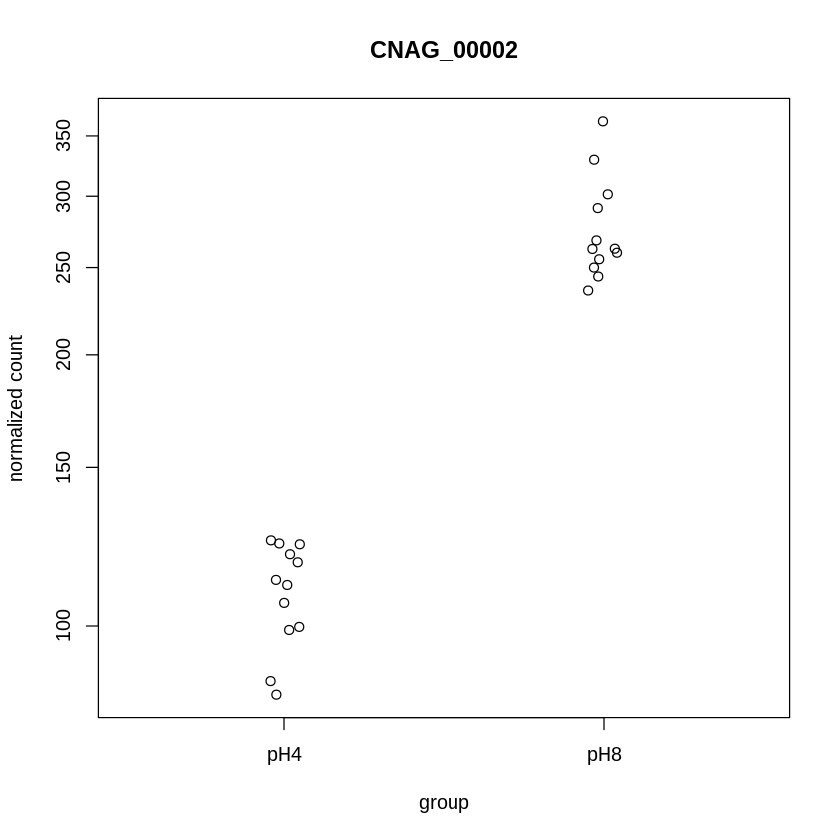

In [118]:
#plotCounts(dds, "CNAG_00002")

In [ ]:
[,c("Label", "genotype", "condition" , "geneexp")]

In [68]:
# first four genes
myres_strainvWT[1:4,]

log2 fold change (MLE): genotype sre1d vs WT 
Wald test p-value: genotype sre1d vs WT 
DataFrame with 4 rows and 6 columns
                   baseMean      log2FoldChange              lfcSE
                  <numeric>           <numeric>          <numeric>
CNAG_00001                0                  NA                 NA
CNAG_00002 192.456384076694 -0.0459290105698189 0.0812849125012254
CNAG_00003 164.990819436254 -0.0432979308487266  0.101045100070341
CNAG_00004 571.054651467718 -0.0347715410374543 0.0464312203030827
                         stat            pvalue              padj
                    <numeric>         <numeric>         <numeric>
CNAG_00001                 NA                NA                NA
CNAG_00002 -0.565037337883909 0.572048368119426 0.675469542016723
CNAG_00003 -0.428501043777338 0.668286373790347 0.756450803050288
CNAG_00004 -0.748882773497678 0.453927864041203 0.566263547566551

 You can get the descriptions for the columns from the DE analysis

In [70]:
data.frame(desc = mcols(myres_strainvWT)$description) 

desc
<fct>
mean of normalized counts for all samples
log2 fold change (MLE): genotype sre1d vs WT
standard error: genotype sre1d vs WT
Wald statistic: genotype sre1d vs WT
Wald test p-value: genotype sre1d vs WT
BH adjusted p-values


manually calculate the baseMean to see if a gene

In [74]:
t(counts(dds, normalize = TRUE)["CNAG_00002",])

1_2019_P_M1,2_2019_P_M1,3_2019_P_M1,4_2019_P_M1,5_2019_P_M1,6_2019_P_M1,7_2019_P_M1,8_2019_P_M1,9_2019_P_M1,10_2019_P_M1,⋯,15_2019_P_M1,16_2019_P_M1,17_2019_P_M1,18_2019_P_M1,19_2019_P_M1,20_2019_P_M1,21_2019_P_M1,22_2019_P_M1,23_2019_P_M1,24_2019_P_M1
99.26872,122.9871,98.48671,123.9726,112.009,119.6346,122.7271,117.1843,105.5822,110.5573,⋯,300.97,249.4876,261.8499,362.8096,254.8584,259.1637,328.8614,261.6647,267.4837,290.5408


In [73]:
mean(counts(dds, normalize = TRUE)["CNAG_00002",])

[1] 192.4564

In [83]:
myres_condition8v4

log2 fold change (MLE): condition pH8 vs pH4 
Wald test p-value: condition pH8 vs pH4 
DataFrame with 8499 rows and 6 columns
                        baseMean     log2FoldChange              lfcSE
                       <numeric>          <numeric>          <numeric>
CNAG_00001                     0                 NA                 NA
CNAG_00002      192.456384076694   1.34351851614176 0.0813854454817818
CNAG_00003      164.990819436254  0.831905577724638  0.101018400723969
CNAG_00004      571.054651467718 0.0871138906737344 0.0465166816365353
CNAG_00005      28.7106195205257   1.29275886849841  0.192729463777133
...                          ...                ...                ...
ENSRNA049551942                0                 NA                 NA
ENSRNA049551964                0                 NA                 NA
ENSRNA049551993                0                 NA                 NA
large_MTrRNA    5333.97356461621  0.948564278537808  0.134340883270906
small_MTrRNA    1705.7

##  P-values

Here we will play with the p-value of the results. Below we demonstrate how the p-value is adjusted using BH method

One can extract the unadjusted p-values as follows

In [75]:
pvalues <- myres_strain$pvalue
length(pvalues)
pvalues[1:4]

[1] 8499

[1]        NA 0.5720484 0.6682864 0.4539279

The BH adjusted p-values can be extracted as

In [76]:
adjp <- myres_strain$padj
length(adjp)
adjp[1:4]

[1] 8499

[1]        NA 0.6754695 0.7564508 0.5662635

Calculate BH adjusted P-values by "hand" using the p.adjust() function. Note that you will not replicate the results you get under the padj column (when looking at the first four rows)

In [77]:
pvalues <- myres_strain$pvalue
BH <- p.adjust(pvalues,"BH")
data.frame(BH = BH[1:4], adjp = adjp[1:4])

BH,adjp
<dbl>,<dbl>
NA,NA
0.6754695,0.6754695
0.7564508,0.7564508
0.5662635,0.5662635


The DESeq2::results function applies "independent" filtering. This is enabled by default. Let's disable and then reexamine the adjusted P-values

In [78]:
myres1 <- results(ddsDE, independentFiltering = FALSE)

In [79]:
myres1

log2 fold change (MLE): genotype WT vs sre1d 
Wald test p-value: genotype WT vs sre1d 
DataFrame with 8499 rows and 6 columns
                        baseMean     log2FoldChange              lfcSE
                       <numeric>          <numeric>          <numeric>
CNAG_00001                     0                 NA                 NA
CNAG_00002      192.456384076694 0.0459290105698189 0.0812849125012254
CNAG_00003      164.990819436254 0.0432979308487266  0.101045100070341
CNAG_00004      571.054651467718 0.0347715410374543 0.0464312203030827
CNAG_00005      28.7106195205257 -0.377056805602812  0.192347436642309
...                          ...                ...                ...
ENSRNA049551942                0                 NA                 NA
ENSRNA049551964                0                 NA                 NA
ENSRNA049551993                0                 NA                 NA
large_MTrRNA    5333.97356461621 -0.396337460272526   0.13434088145007
small_MTrRNA    1705.7

 We can now replicate the results

In [ ]:
pvalues1 <- myres1$pvalue
BH1 <- p.adjust(pvalues1[!is.na(pvalues)], "BH")
data.frame(
    BH   = BH1[1:4],
    adjp = myres1$padj[1:4])

##  Subset and reorder the results

In [ ]:
class(myres_strain)

In [ ]:
summary(myres_strain, 0.05)

 You can sort the results by say the unadjusted P-values

In [ ]:
results(ddsDE, contrast = c("Strain", "H99", "mar1d"), tidy = TRUE) %>%
    arrange(padj) %>% 
    head(4)

To get the list of genes with unadjusted P-values < 0.00001 and absolute log2 FC of more than 4

In [ ]:
results(ddsDE, contrast = c("Strain", "H99", "mar1d"), tidy = TRUE) %>%
    filter(padj < 0.00001) %>%
    filter(abs(log2FoldChange) > 4)

The P-values for the four top genes are beyond machine precision. You can use the format.pval() function to properly format the P-values. PLEASE promote ending the practice of publishing P-values below machine precision.  (that would be akin to stating the weight of an object that weighs less than one pound with a scale whose minimum weight spec is 1 pound).

In [ ]:
results(ddsDE, contrast = c("Strain", "H99", "mar1d"), tidy = TRUE) %>%
    filter(padj < 0.00001) %>%
        filter(abs(log2FoldChange) > 4) %>%
            mutate(pval = format.pval(pvalue))

Let's look at a volcano plot

In [ ]:
plot(myres_strain$log2FoldChange,
     -log10(myres_strain$padj),
     pch  = 19, 
     cex  = 0.3,
     xlab = "Log2 FC",
     ylab = "-log10(BH Adjusted P-value)")

Exercise: Annotate the hits with adjusted P-values < 0.05 and absolute log2 FC greater than 2 in red

In [ ]:
plot(myres_strain$log2FoldChange,
     -log10(myres_strain$padj),
     pch  = 19,
     cex  = 0.3,
     xlab = "Log2 FC",
     ylab = "-log10(BH Adjusted P-value)",
     col  = ifelse(myres_strain$padj < 0.05 & abs(myres_strain$log2FoldChange) > 2,
                   "red",
                   "black"))

# Converting/Normalizing Counts to "Expressions"

##  Normalized Counts
We have already shown how to "normalize" the counts using the estimated size factors

In [ ]:
head(counts(dds, normalize = TRUE), 3)

Plot the counts stratified by treatment for the 2nd gene. Later we will compare the expression values in more detail in the section of regularized log transformation (rlog transformation). In the section of rlog transformation, the media and strain will be indicated/labeled in the plot.

In [ ]:
results(ddsDE, contrast = c("Strain", "H99", "mar1d"), tidy = TRUE) %>%
    arrange(padj) %>% 
    head(4)

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow = c(1, 2))
plotCounts(dds, 2,            intgroup = "Strain")
plotCounts(dds, "CNAG_03398", intgroup = "Strain")
par(mfrow = c(1, 1))

In [ ]:
results(ddsDE, contrast = c("Media", "YPD", "TC"), tidy = TRUE) %>%
    arrange(padj) %>% 
    head(4)

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow = c(1, 2))
plotCounts(dds, 2,            intgroup = "Media")
plotCounts(dds, "CNAG_03398", intgroup = "Media")
par(mfrow = c(1, 1))

#  FPM
Another approach is to FPM: fragments per million mapped fragments

In [ ]:
head(fpm(dds), 3)

Let's calculate the FPM manually. For gene $i$ sample $j$, the FPM is defined as $\frac{K_{ij}}{D_j}\times 10^{6}$ where $D_j=\sum_{i=1} K_{ij}$ is the read depth for sample $j$. First get the read depth for each sample

In [ ]:
D <- colSums(counts(dds)) # colSums: sum of each column, where each column represents a sample
D

By default, the fpm() function uses a robust approach. We will disable this right now as to replicate the standard FPM. Let's look at gene 1

In [ ]:
fpm1 <- fpm(dds, robust = FALSE)[1,]
fpm1

Now get the raw counts for gene 1

In [ ]:
cnt1 <- counts(dds)[1,]
cnt1

 Now calculate the FPM for gene 1

In [ ]:
myfpm1 <- cnt1 / D * 1e6
myfpm1

Let's summarize what we have done:

In [ ]:
tmp <- bind_rows(D, cnt1, myfpm1, fpm1)
tmp <- t(tmp)
colnames(tmp) <- c("col_sums", "count_gene1", "FPM_gene1_manual", "FPM_gene1_DESeq")
tmp

This is how you check if two numeric columns are "equal"? One approach is to calculate the maximum absoute difference

In [ ]:
max(abs(fpm1 - myfpm1))

The above approach is also helpful in establishing if the difference is "small". Another approach to test for equality to use the all.equal() function

In [ ]:
all.equal(fpm1, myfpm1)

 It is generally a bad idea to compare numeric vectors using == (e.g., fpm1==myfpm1)

### FPKM

 To calculate the FPKM (fragments per kilobase per million mapped fragments) we need to add annotation to assign the feature lengths. More specifically, for gene $i$ sample $j$, the FPKM is defined as $\frac{K_{ij}}{\ell_i D_j}\times 10^3 \times 10^{6}$ where $\ell_i$ is the "length" of gene $i$ (fragments for each $10^3$ bases in the gene for every  $\frac{D_j}{10^6}$ fragments. More on this later.

# Regularized log transformation
The regularized log transform can be obtained using the [rlog() function](https://rdrr.io/bioc/DESeq2/man/rlog.html). Note that an important argument for this function is blind (TRUE by default). The default "blinds" the normalization to the design. This is very important so as to not bias the analyses (e.g. class discovery) 

In [ ]:
rld <- rlog(dds, blind = TRUE)

## Dendrogram of samples: showing strain & media of each sample

Hierarchical clustering using rlog transformation

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 5)
dists <- dist(t(assay(rld)))
plot(hclust(dists)) 

Store the dendrogram of samples using hierarchical clustering

In [ ]:
assay(rld) %>%
    t() %>%
    dist %>%
    hclust(method = "complete") %>%
    as.dendrogram ->
    mydend

Dendrogram of samples: showing strain of each sample

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 5)
dendplot(mydend, columnData, 
         "Strain",    # variable that show in label
         "Strain",    # variable that define color
         "Media") %>% # variable that define shape of points
    plot

Dendrogram of samples: showing media of each sample

In [ ]:
dendplot(mydend, columnData, "Media", "Strain", "Media") %>% plot

Dendrogram of samples: showing sample label

In [ ]:
dendplot(mydend, columnData, "Label", "Media", "Strain") %>% plot

PC Analysis using the rlog transformation

In [ ]:
library(ggplot2)
options(repr.plot.width = 7, repr.plot.height = 4)
plotPCA(rld, intgroup = "Media") + geom_text(label=columnData$Label, color="black")

Store the plot into a pdf

In [ ]:
pdf(file.path(IMGDIR, "dendrogram.pdf"))
dendplot(mydend, columnData, "Strain", "Strain", "Media") %>% plot
dendplot(mydend, columnData, "Media", "Strain", "Media") %>% plot
dendplot(mydend, columnData, "Label", "Strain", "Media") %>% plot
graphics.off()

# Variance Stabilizing Transformation (vst) and mean-variance modelling at the observational level (voom)

 Two other normalization approaches for RNA-Seq count data are provided by the functions DESeq2::vst and limma::voom (note that for the latter one needs the limma package).From ? DESeq2::vst
"This function calculates a variance stabilizing transformation (VST) from the fitted dispersion-mean relation(s) and then transforms the count data (normalized by division by the size factors or normalization factors), yielding a matrix of values which are now approximately homoskedastic (having constant variance along the range of mean values). The transformation also normalizes with respect to library size."Compared to DESeq2::rlog
"The ‘rlog’ is less sensitive to size factors, which can be an issue when size factors vary widely. These transformations are useful when checking for outliers or as input for machine learning techniques such as clustering or linear discriminant analysis."From ? limma::voom
"Transform count data to log2-counts per million (logCPM), estimate the mean-variance relationship and use this to compute appropriate observation-level weights. The data are then ready for linear modelling." Get VST transformation

In [ ]:
VST <- vst(dds)
class(VST)

Get the VST matrix

In [ ]:
VSTmat <- assay(VST)
dim(VSTmat)
VSTmat[1:10,]

Get voom transformation (note that according to ? limma::voom, the function is expecting raw counts

In [ ]:
VOOM <- limma::voom(counts(dds))

Get the VOOM matrix

In [ ]:
VOOMmat <- VOOM$E
dim(VOOMmat)
VOOMmat[1:10,]

# Appendix: Multiplicitive Model

In [ ]:
### Make DESeq object on the basis of the counts
dds_mult <- DESeqDataSetFromMatrix(countData, columnData, ~ Media + Strain + Media:Strain)
### Estimate Size Factors
dds_mult <- estimateSizeFactors(dds_mult)
### Estimate Dispersion parameters (for each gene)
dds_mult <- estimateDispersions(dds_mult)
### Fit NB MLE model
dds_mult <- DESeq(dds_mult)
### Rlog "normalized" expressions
rld <- rlog(dds_mult)

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 5)
grid.arrange(
    myinteractplot(rld, "CNAG_03398", "Strain"),
    myinteractplot(rld, "CNAG_03623", "Strain"),
    myinteractplot(rld, "CNAG_00727", "Strain"),
    myinteractplot(rld, "CNAG_02587", "Strain"),
    ncol=2)

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 5)
grid.arrange(
    myinteractplot(rld, "CNAG_03398", "media"),
    myinteractplot(rld, "CNAG_12988", "media"),
    myinteractplot(rld, "CNAG_00183", "media"),
    myinteractplot(rld, "CNAG_02083", "media"),
    ncol=2)

# Appendix: Get Session Information

In [ ]:
sessionInfo()

In [87]:
dds@colData

DataFrame with 24 rows and 23 columns
                    Label sample_year       group enrich_rep RNA_sample_num
              <character>   <numeric> <character>  <numeric>      <numeric>
1_2019_P_M1   1_2019_P_M1        2019           P          1              1
2_2019_P_M1   2_2019_P_M1        2019           P          1              2
3_2019_P_M1   3_2019_P_M1        2019           P          1              3
4_2019_P_M1   4_2019_P_M1        2019           P          1              4
5_2019_P_M1   5_2019_P_M1        2019           P          1              5
...                   ...         ...         ...        ...            ...
20_2019_P_M1 20_2019_P_M1        2019           P          1             20
21_2019_P_M1 21_2019_P_M1        2019           P          1             21
22_2019_P_M1 22_2019_P_M1        2019           P          1             22
23_2019_P_M1 23_2019_P_M1        2019           P          1             23
24_2019_P_M1 24_2019_P_M1        2019           P 